In [2]:
import re
import sys
import time
import warnings
from datetime import datetime
from pprint import pprint

import gensim
import gensim.corpora as corpora
import matplotlib as plt
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.graph_objs as go
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pytrends
import seaborn as sns
from gensim import models
from gensim.models.coherencemodel import CoherenceModel
from gensim.utils import simple_preprocess
from matplotlib import *
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from plotly import tools as tls
from plotly.subplots import make_subplots
from pylab import *
from pytrends.request import TrendReq
from scipy import stats
from scipy.stats import spearmanr
from wordcloud import WordCloud

warnings.filterwarnings('ignore')

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()

/home/luyao/.local/share/virtualenvs/blockchain-ethics-3DrjvFmO/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
[nltk_data] Downloading package stopwords to /home/luyao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/luyao/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/luyao/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
# set default directory
if os.getcwd().split('/')[-1] != 'blockchain-ethics':
    os.chdir('..')
print(f'working dir: {os.getcwd()}')

working dir: /home/luyao/blockchain-ethics


In [4]:
df_mev = pd.read_csv('data/mev_tweets.csv').drop(["Unnamed: 0"], axis =1)
display(df_mev.head())


Date  \
0  2022-09-30 20:48:24+00:00   
1  2022-09-30 20:47:32+00:00   
2  2022-09-30 20:46:41+00:00   
3  2022-09-30 18:53:00+00:00   
4  2022-09-30 18:43:13+00:00   

                                              Tweets  
0  🚨🚨🚨 Keep an eye on this #SandwichAttacker!😈😈😈\...  
1  🚨🚨🚨 Keep an eye on this #SandwichAttacker!😈😈😈\...  
2  🚨🚨🚨 Keep an eye on this #SandwichAttacker!😈😈😈\...  
3  @yourcryptodj #MEV tokens!\n\n#GameFi #blockch...  
4  @aleksa_crypto #MEV tokens: #GameFi #Metaverse...

In [5]:
df_flashbots = pd.read_csv('data/flashbots_tweets.csv').drop(["Unnamed: 0"], axis =1)
display(df_flashbots.head())

Date  \
0  2022-09-30 21:05:08+00:00   
1  2022-09-30 13:06:33+00:00   
2  2022-09-30 10:56:26+00:00   
3  2022-09-30 08:45:35+00:00   
4  2022-09-30 06:55:41+00:00   

                                              Tweets  
0  What is / are the flashbots twitter accounts?\...  
1  Près d'un bloc #Ethereum sur deux en cours de ...  
2  #Labrys CEO Lachlan Feeney is trying to raise ...  
3  45% of ETH validators now complying with US sa...  
4  New post: 45% of ETH validators now complying ...

In [6]:
def clean_data(df):
  df['paper_text_processed'] = \
  df['Tweets'].map(lambda x: re.sub('[,\.!?]', '', str(x)))
  df['paper_text_processed'] = \
  df['paper_text_processed'].map(lambda x: x.lower())
  return df

In [7]:
df_mev2=clean_data(df_mev)
df_flashbots=clean_data(df_flashbots)

### Time Series

In [8]:
def ts_tweet(df):
  df['len'] = df['paper_text_processed'].str.split().str.len()
  df["Date"]=pd.to_datetime(df["Date"],errors='coerce',utc=True)
  df["day"]=df["Date"].dt.date
  c=pd.DataFrame({'Tweet Counts' : df.groupby(by=["day"])["Tweets"].count()}).reset_index()
  tweet_volume=c["Tweet Counts"].values.tolist()
  a=pd.DataFrame({'Tweet Length' : df.groupby(by=["day"])["len"].mean()}).reset_index()
  tweet_len=a["Tweet Length"].values.tolist()
  return tweet_len, tweet_volume, df,c,a

In [9]:
# for mev
tweet_len_mev2, tweet_volume_mev2, df_mev,df_tweetcoun_mev,df_tweetlen_mev = ts_tweet(df_mev2)[0], ts_tweet(df_mev2)[1], ts_tweet(df_mev2)[2],ts_tweet(df_mev2)[3],ts_tweet(df_mev2)[4]
del tweet_len_mev2[0:2]
del tweet_volume_mev2[0:2]

In [10]:
display(df_tweetcoun_mev.head())
display(df_tweetlen_mev.head())

day  Tweet Counts
0  2019-01-01             9
1  2019-01-02             6
2  2019-01-03             6
3  2019-01-04             9
4  2019-01-05             7

day  Tweet Length
0  2019-01-01     22.666667
1  2019-01-02     23.000000
2  2019-01-03     23.000000
3  2019-01-04     21.777778
4  2019-01-05     21.142857

In [11]:
# For flashbots
tweet_len_flashbots, tweet_volume_flashbots, df_flashbots,df_tweetcoun_flashbots,df_tweetlen_flashbots = ts_tweet(df_flashbots)[0], ts_tweet(df_flashbots)[1], ts_tweet(df_flashbots)[2],ts_tweet(df_flashbots)[3],ts_tweet(df_flashbots)[4]
del tweet_len_flashbots[0:2]
del tweet_volume_flashbots[0:2]

In [12]:
display(df_tweetcoun_flashbots.head())
display(df_tweetlen_flashbots.head())

day  Tweet Counts
0  2019-01-25             1
1  2019-01-26            12
2  2019-06-12             1
3  2019-08-01             1
4  2019-11-08             1

day  Tweet Length
0  2019-01-25         11.00
1  2019-01-26         10.75
2  2019-06-12          9.00
3  2019-08-01         20.00
4  2019-11-08         27.00

### Google Trend

In [13]:
dftrendmev = pd.read_csv("data/trend_mev.csv")

In [14]:
display(dftrendmev.head())

date  mev_unscaled  mev_monthly isPartial  scale  mev
0  2019-01-01            30          NaN       NaN    NaN  NaN
1  2019-01-02            29          NaN       NaN    NaN  NaN
2  2019-01-03            25          NaN       NaN    NaN  NaN
3  2019-01-04            48          NaN       NaN    NaN  NaN
4  2019-01-05           100          NaN       NaN    NaN  NaN

In [15]:
dftrendmev["date"] = pd.to_datetime(dftrendmev["date"])
datemev = dftrendmev["date"]
valuemev = dftrendmev["mev_unscaled"]

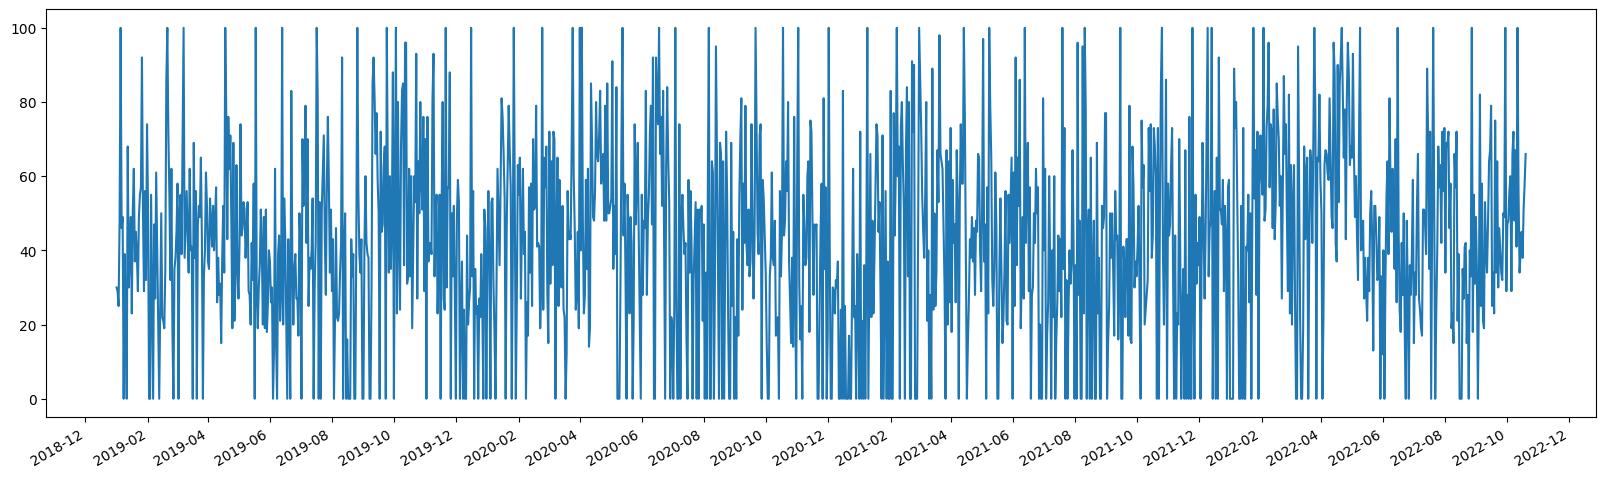

In [16]:
fig, ax = plt.subplots(figsize=(20, 6))

half_year_locator = mdates.MonthLocator(interval=2)
year_month_formatter = mdates.DateFormatter("%Y-%m")
# Same as above
ax.xaxis.set_major_locator(half_year_locator)
ax.xaxis.set_major_formatter(year_month_formatter)
ax.plot(datemev, valuemev)

# Rotates and right aligns the x labels. 
# Also moves the bottom of the axes up to make room for them.
fig.autofmt_xdate()

In [17]:
dftrendflashbots = pd.read_csv("data/trend_flashbots.csv")

In [18]:
display(dftrendflashbots.head())

date  flashbots_unscaled  flashbots_monthly isPartial  scale  \
0  2019-01-01                   0                NaN       NaN    NaN   
1  2019-01-02                   0                NaN       NaN    NaN   
2  2019-01-03                   0                NaN       NaN    NaN   
3  2019-01-04                   0                NaN       NaN    NaN   
4  2019-01-05                  78                NaN       NaN    NaN   

   flashbots  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        NaN

In [19]:
dftrendflashbots["date"] = pd.to_datetime(dftrendflashbots["date"])
dateflashbots = dftrendflashbots["date"]
valueflashbots = dftrendflashbots["flashbots_unscaled"]

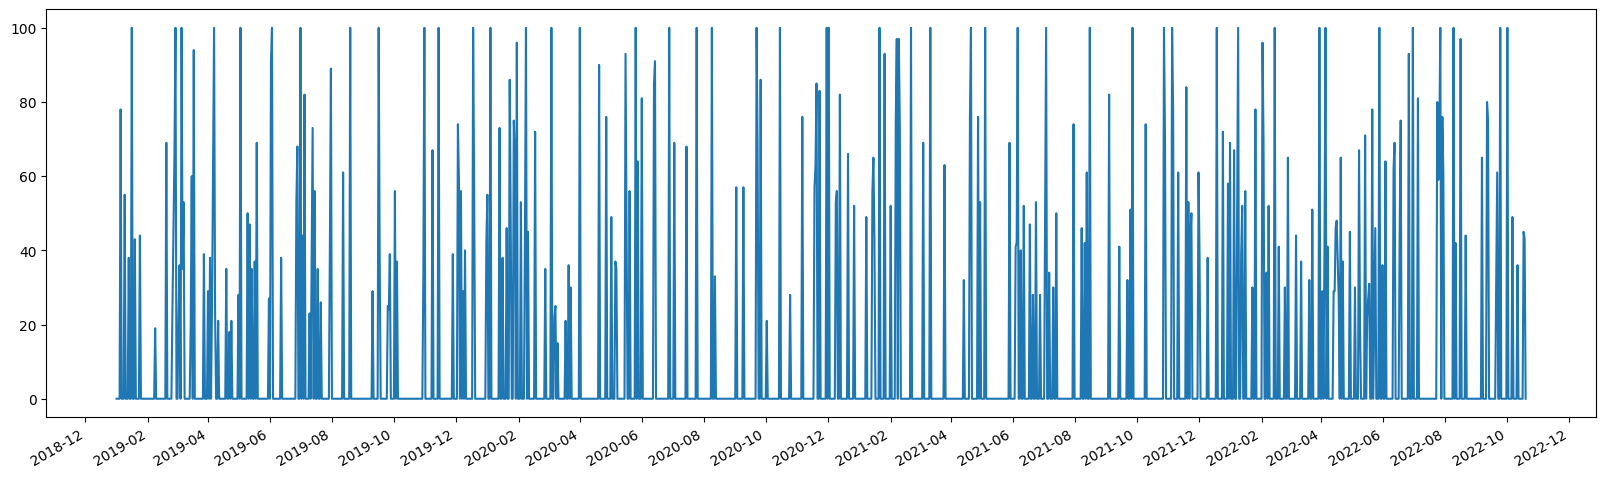

In [20]:
fig, ax = plt.subplots(figsize=(20, 6))

half_year_locator = mdates.MonthLocator(interval=2)
year_month_formatter = mdates.DateFormatter("%Y-%m")
# Same as above
ax.xaxis.set_major_locator(half_year_locator)
ax.xaxis.set_major_formatter(year_month_formatter)
ax.plot(dateflashbots, valueflashbots)

# Rotates and right aligns the x labels. 
# Also moves the bottom of the axes up to make room for them.
fig.autofmt_xdate()

#### Relation between MEV twitter volume and google trend

In [21]:
# Define tweet volume variable #MEV

df_tweetcoun_mev["date"] = pd.to_datetime(df_tweetcoun_mev["day"])
datetweetcounmev = df_tweetcoun_mev["day"]
valuetweetcounmev = df_tweetcoun_mev["Tweet Counts"]


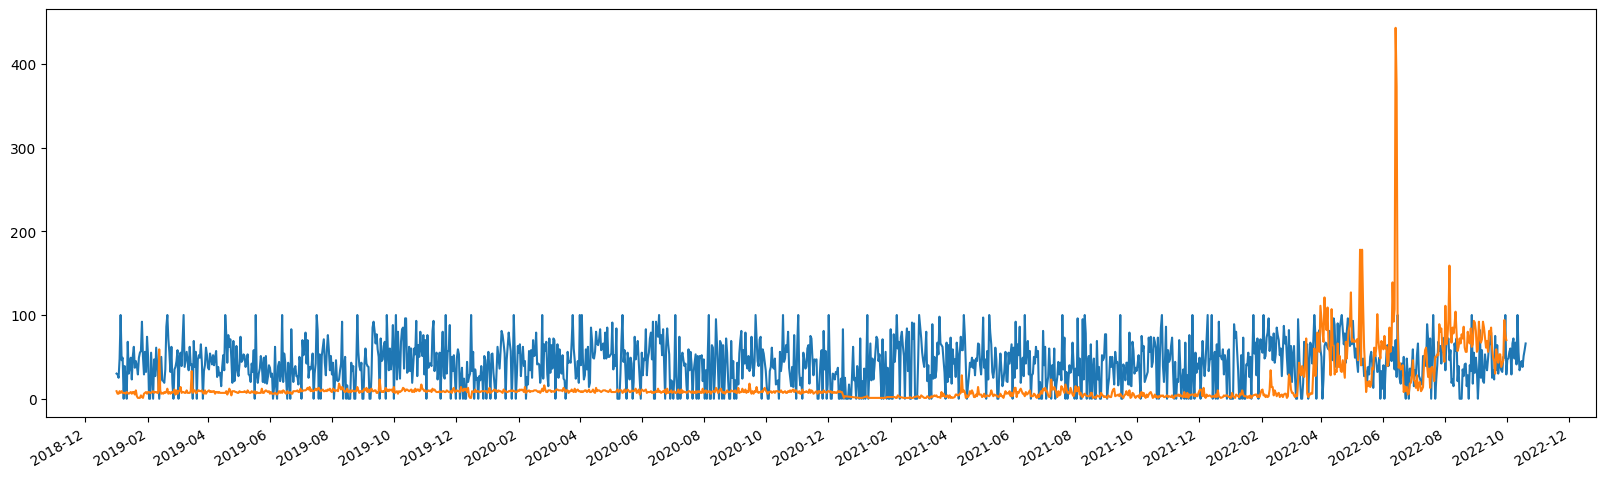

In [22]:
fig, ax = plt.subplots(figsize=(20, 6))

half_year_locator = mdates.MonthLocator(interval=2)
year_month_formatter = mdates.DateFormatter("%Y-%m")
# Same as above
ax.xaxis.set_major_locator(half_year_locator)
ax.xaxis.set_major_formatter(year_month_formatter)
ax.plot(datemev, valuemev)

ax.plot(datetweetcounmev,valuetweetcounmev)

# Rotates and right aligns the x labels. 
# Also moves the bottom of the axes up to make room for them.
fig.autofmt_xdate()


#### Relation between MEV google trend and flashbots google trend

In [23]:
# Spearman Correlation Test
dftrendconcat= pd.concat([dftrendmev, dftrendflashbots])

In [24]:
display(dftrendconcat.head())

date  mev_unscaled  mev_monthly isPartial  scale  mev  \
0 2019-01-01          30.0          NaN       NaN    NaN  NaN   
1 2019-01-02          29.0          NaN       NaN    NaN  NaN   
2 2019-01-03          25.0          NaN       NaN    NaN  NaN   
3 2019-01-04          48.0          NaN       NaN    NaN  NaN   
4 2019-01-05         100.0          NaN       NaN    NaN  NaN   

   flashbots_unscaled  flashbots_monthly  flashbots  
0                 NaN                NaN        NaN  
1                 NaN                NaN        NaN  
2                 NaN                NaN        NaN  
3                 NaN                NaN        NaN  
4                 NaN                NaN        NaN

In [25]:
stats.spearmanr(dftrendmev['mev_unscaled'],dftrendflashbots['flashbots_unscaled'])

SpearmanrResult(correlation=0.002964570460906889, pvalue=0.9121330800055509)

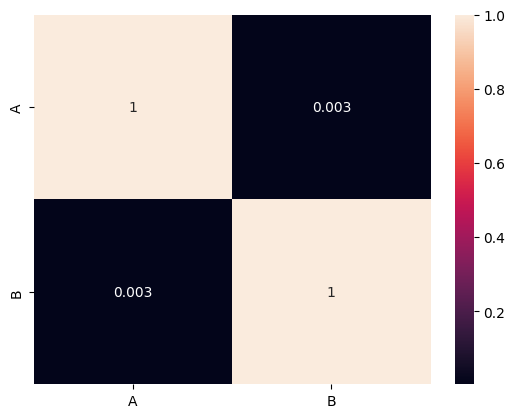

In [26]:
dfcorr = pd.DataFrame({'A': dftrendmev['mev_unscaled'],
                   'B': dftrendflashbots['flashbots_unscaled']})

corr = dfcorr.corr(method = 'spearman')

sns.heatmap(corr, annot = True)

plt.show()

In [27]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu',"u","e","i鈥檓",'use','https',"tco","i'm","-","de","amp","&amp;","🤖️","https://tco/6nci29u08n","):","(",")","u"])

[nltk_data] Downloading package stopwords to /home/luyao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
df_mev2['tweet_without_stopwords'] = df_mev2["paper_text_processed"].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split() if word not in (stop_words)]))
df_flashbots['tweet_without_stopwords'] = df_flashbots["paper_text_processed"].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split() if word not in (stop_words)]))

In [29]:
tokenSpace = tokenize.WhitespaceTokenizer()
def counter(text, columnText, quantity):
    allWords = ' '.join([text for text in text[columnText].astype('str')])
    tokenPhrase = tokenSpace.tokenize(allWords)
    frequency = nltk.FreqDist(tokenPhrase) 
    dfFrequency = pd.DataFrame({"Word": list(frequency.keys()), "Frequency": list(frequency.values())}) 
    dfFrequency = dfFrequency.nlargest(columns = "Frequency", n = quantity)
    dfFrequency=dfFrequency.reset_index().reset_index()
    return dfFrequency

In [30]:
df1=counter(df_mev2, 'tweet_without_stopwords', 31)
df2=counter(df_flashbots, 'tweet_without_stopwords', 31)

In [31]:
display(df1.head())
display(df2.head())

level_0  index        Word  Frequency
0        0      4        #mev      20428
1        1     81       using       8296
2        2      6        made       8099
3        3    106  #arbitrage       7494
4        4  45718     ecocent       5790

level_0  index        Word  Frequency
0        0      8  #flashbots        834
1        1    293        #mev        191
2        2    149         mev        175
3        3   1939       $mist        115
4        4     63         new         92

In [32]:
df1.to_csv('data/mev_frequent_keywords.csv')
df2.to_csv('data/flashbots_frequent_keywords.csv')

#### Wordcount Graph

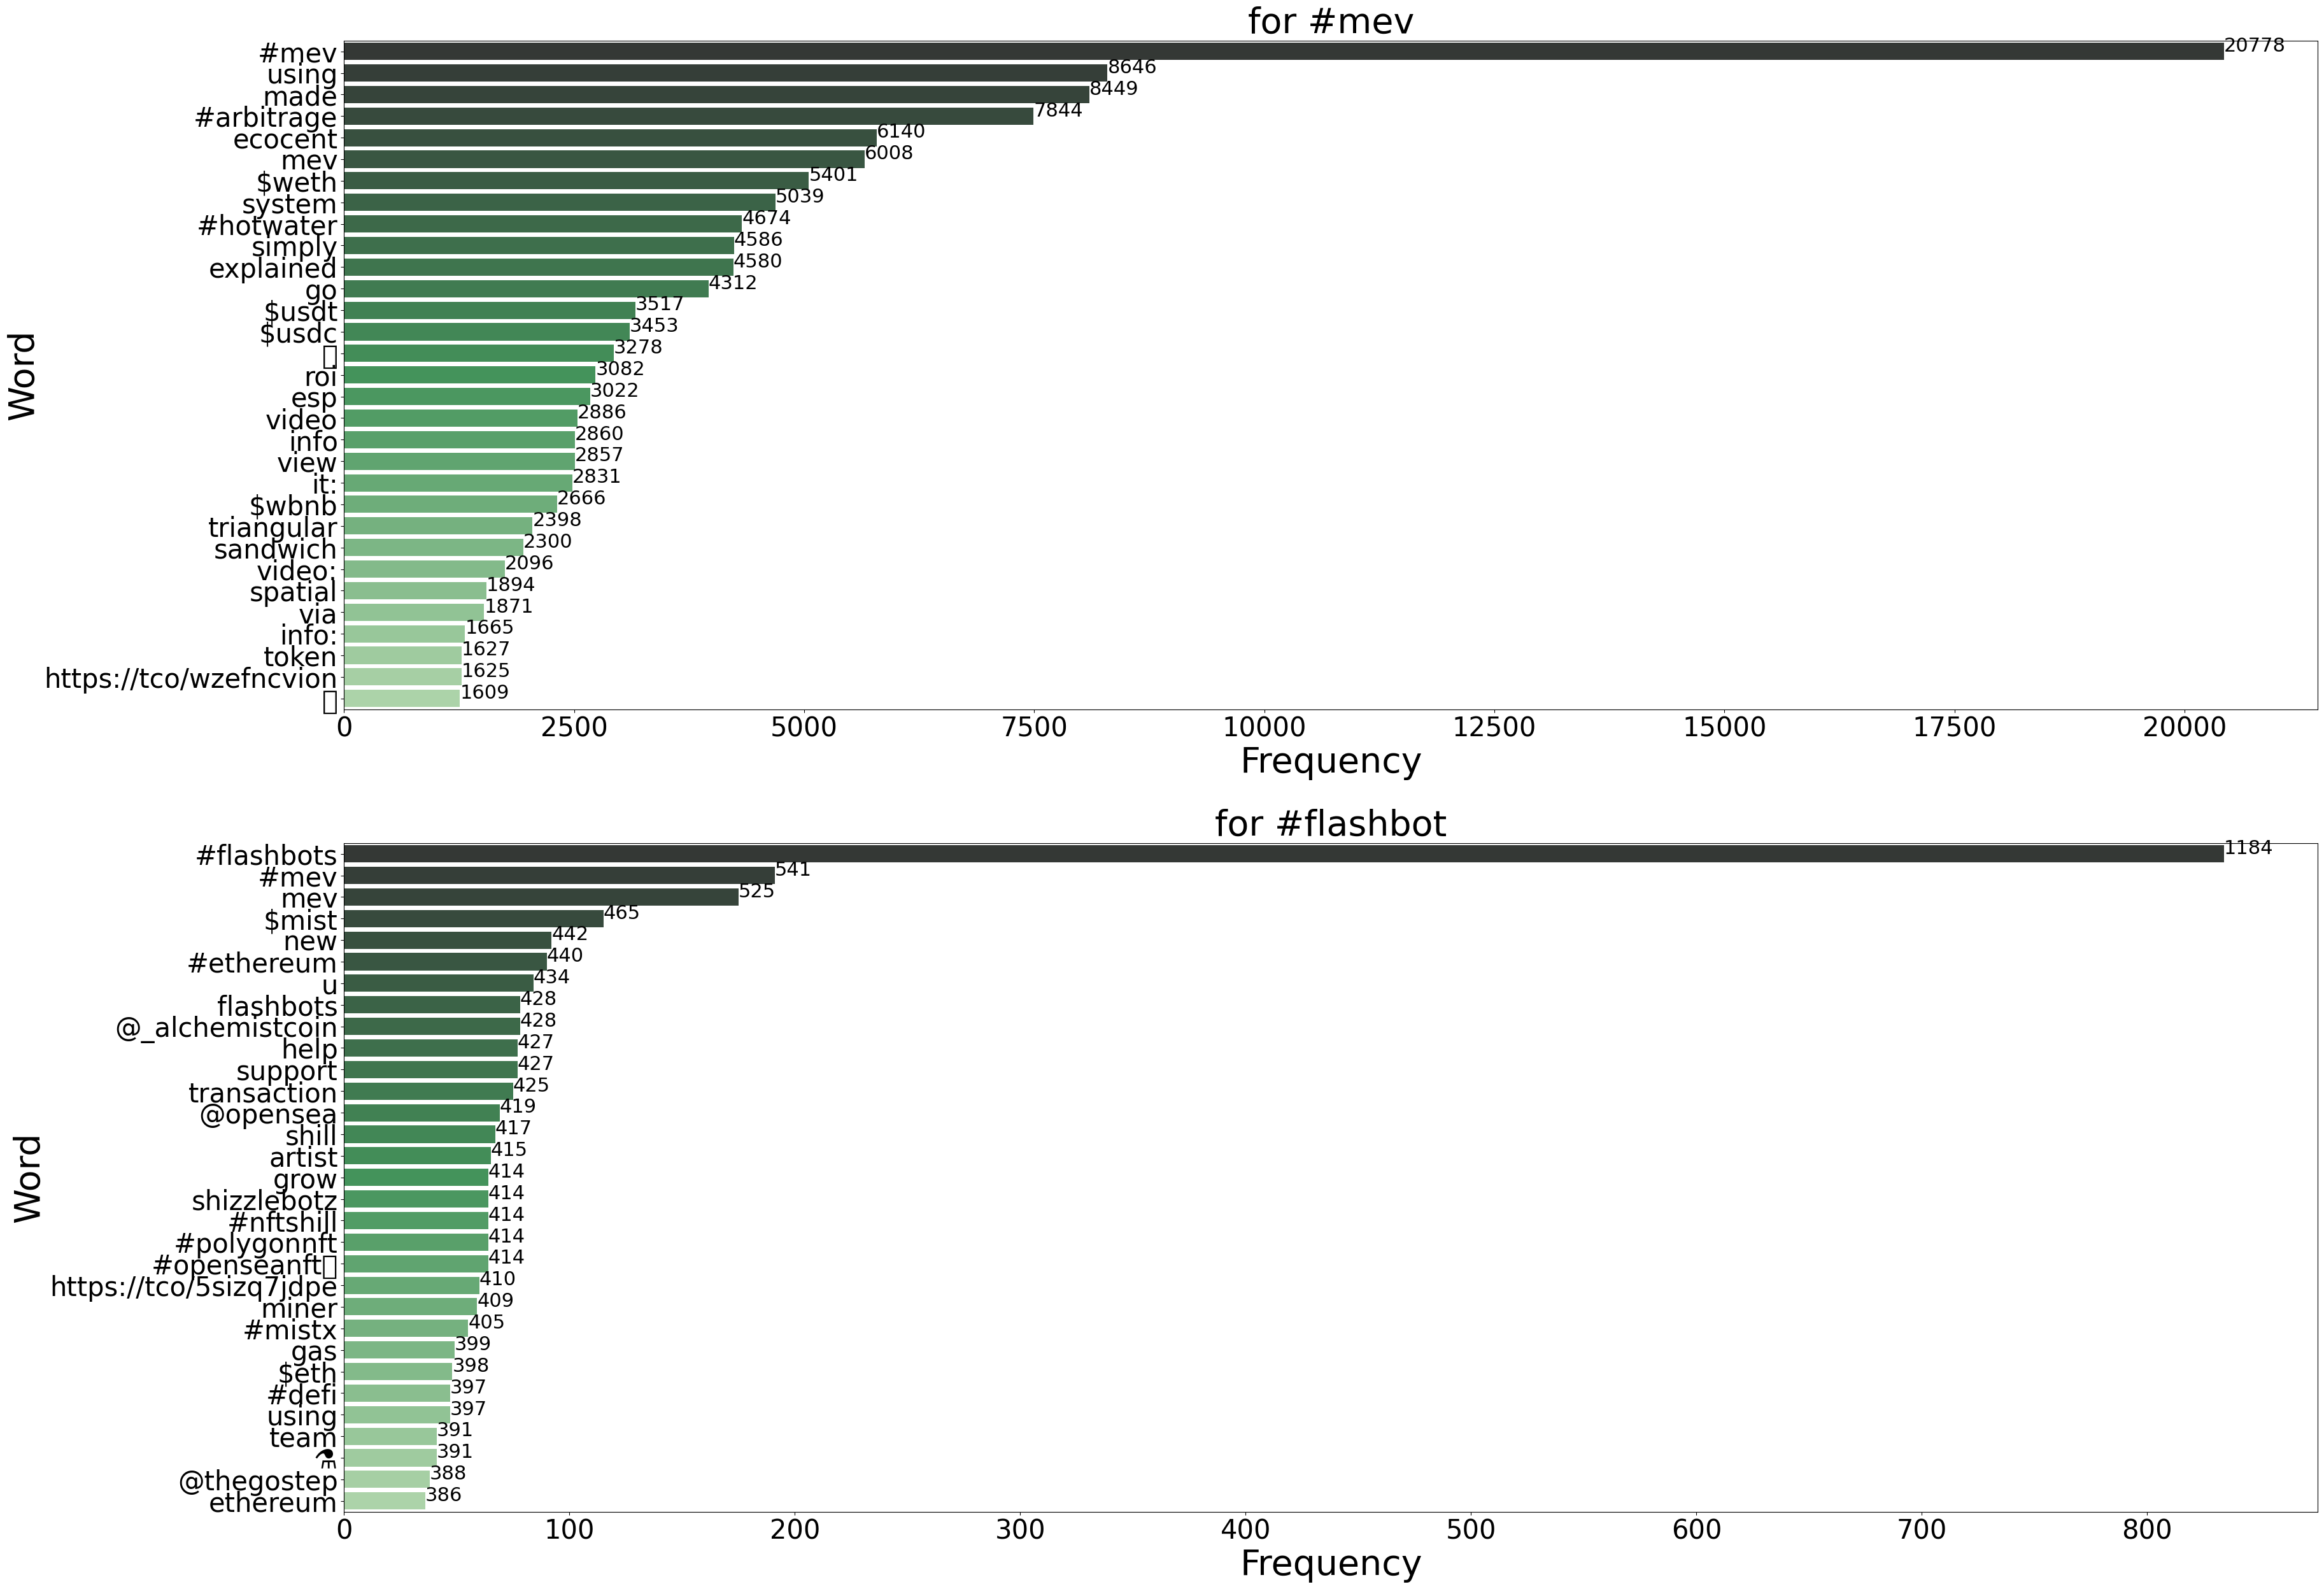

In [33]:
ig, axs = plt.subplots(2,figsize=(40,30))
axs[0].set_title('for #mev',fontsize=40)
axs[1].set_title('for #flashbot',fontsize=40)

pal1 = sns.color_palette("Greens_d", len(df1["Frequency"]))
rank1 = df1["Frequency"].argsort().argsort()
ax1=sns.barplot(data =df1, x = "Frequency", y = "Word", palette=np.array(pal1[::1])[rank1], ax=axs[0])

for index, row in df1.iterrows():
  ax1.text(row.Frequency,row.level_0,int(row.Frequency)+350, color='black', ha="left",fontsize=22)

pal2 = sns.color_palette("Greens_d", len(df2["Frequency"]))
rank2 = df2["Frequency"].argsort().argsort()
ax2=sns.barplot(data =df2, x = "Frequency", y = "Word", palette=np.array(pal2[::1])[rank1], ax=axs[1])

for index, row in df2.iterrows():
  ax2.text(row.Frequency,row.level_0,int(row.Frequency)+350, color='black', ha="left",fontsize=22)

ax1.tick_params(axis='both', which='major', labelsize=30)
ax1.set_xlabel("Frequency",fontsize=40)
ax1.set_ylabel("Word",fontsize=40)
ax2.tick_params(axis='both', which='major', labelsize=30)
ax2.set_xlabel("Frequency",fontsize=40)
ax2.set_ylabel("Word",fontsize=40)

plt.show()

#### Wordcloud

In [34]:
# Join the different processed titles together.
long_string = ','.join(list(df_flashbots['paper_text_processed'].values))
stop_words = stopwords.words('english')

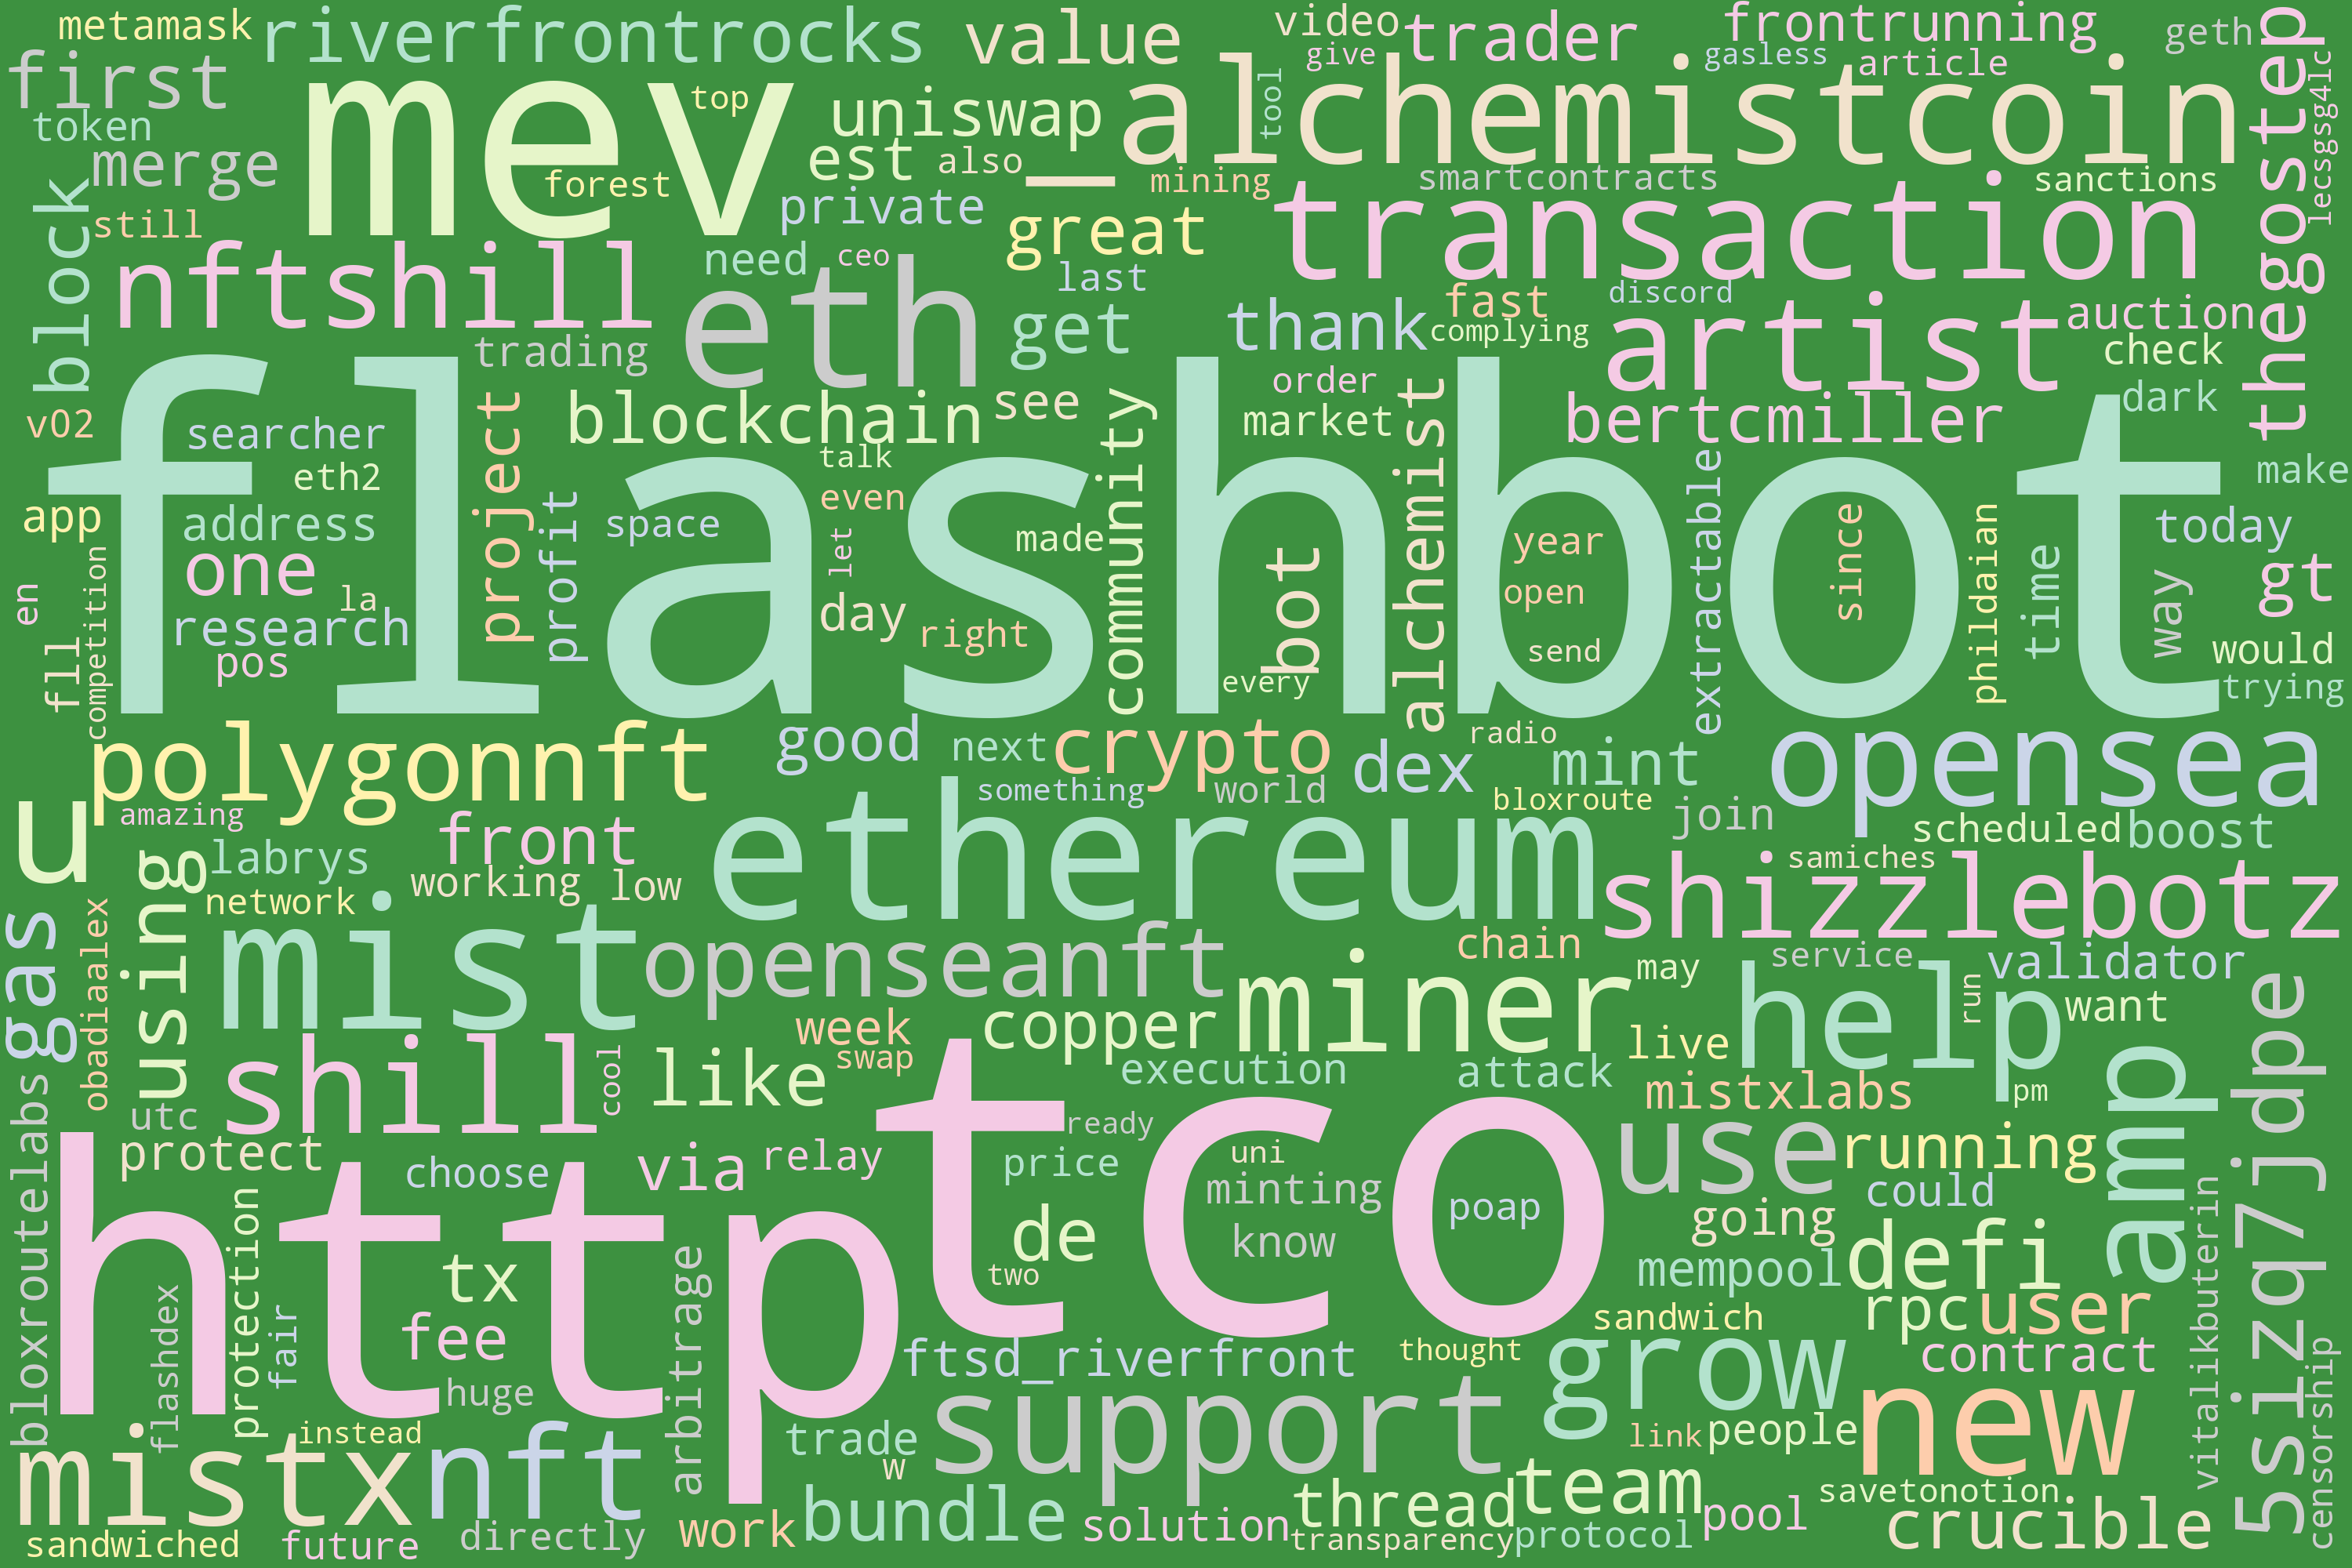

In [35]:
wordcloud = WordCloud(width= 3000, height = 2000, random_state=1, background_color='#3D9140', colormap='Pastel2', collocations=False, stopwords =stop_words).generate(long_string)

# show the word cloud
wordcloud.to_image()

In [36]:
long_string = ','.join(list(df_mev2['paper_text_processed'].values))
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','https',"tco","i'm","-","de","amp","&amp;"])

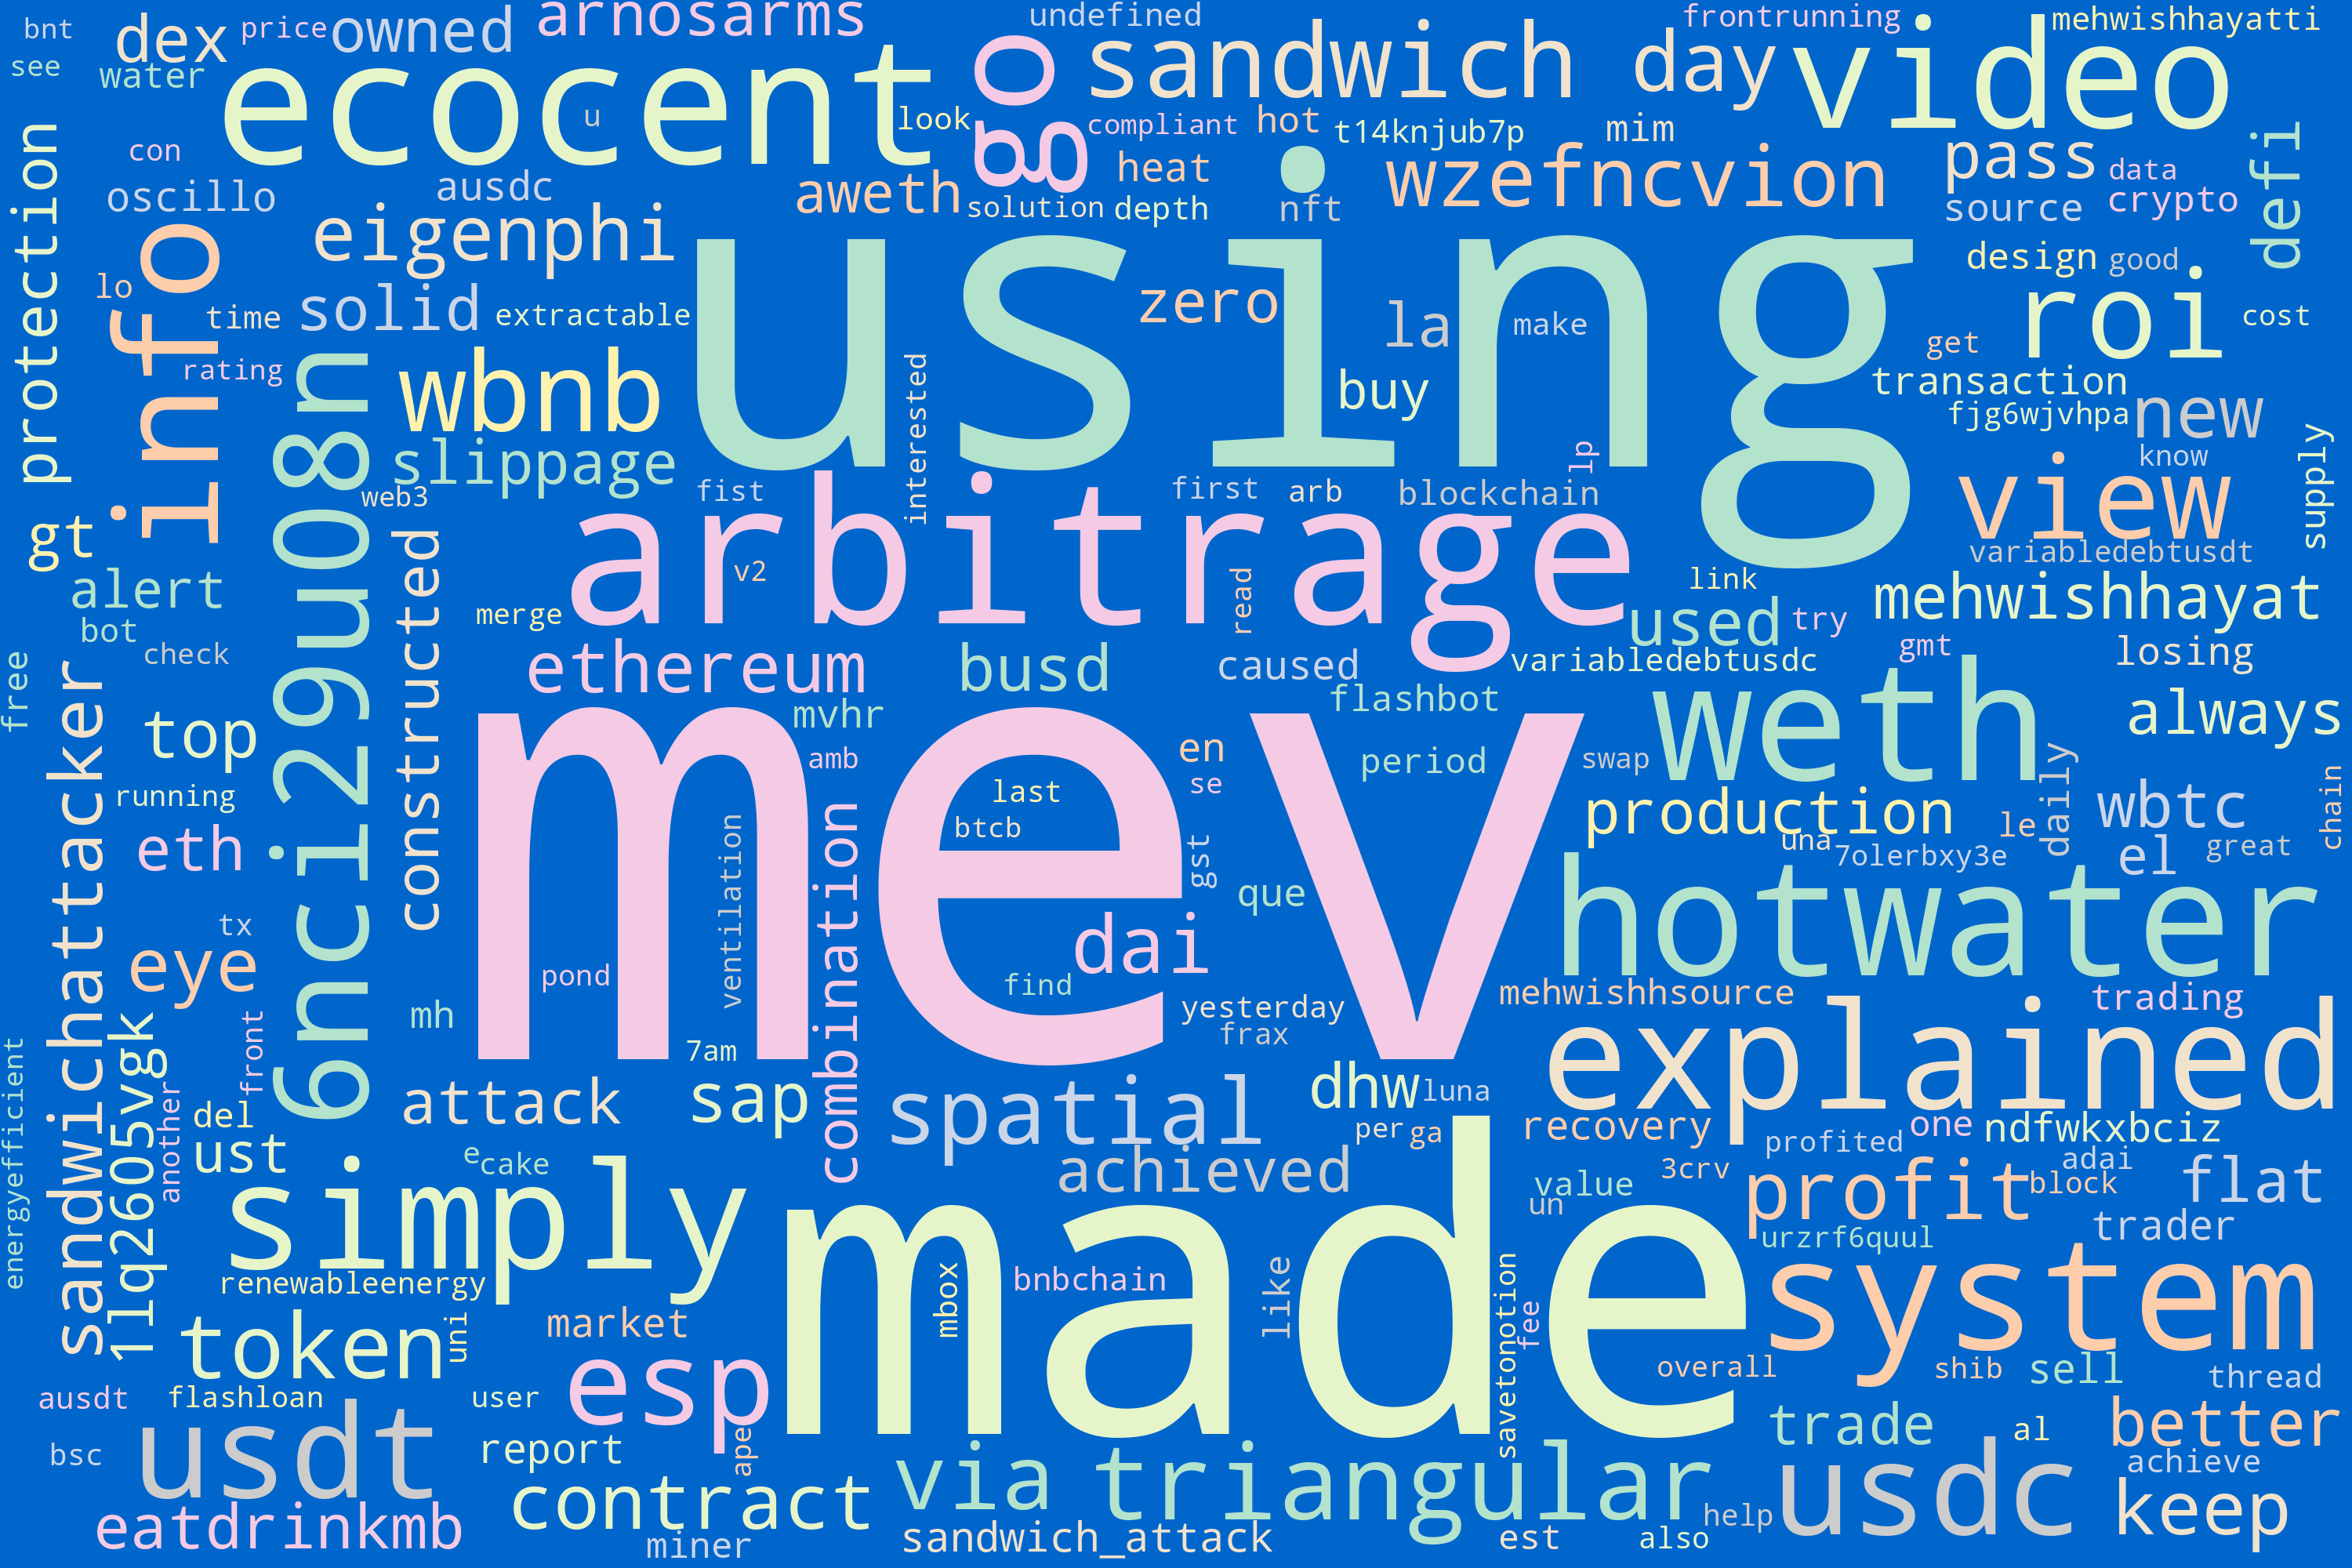

In [37]:
wordcloud = WordCloud(width= 3000, height = 2000, random_state=1, background_color='#0066CC', colormap='Pastel2', collocations=False, stopwords =stop_words).generate(long_string)

# Show the word cloud
wordcloud.to_image()

## LDA analysis for tag mev & flashbots

In [38]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','https', "tco","-","de","amp","la","et","les","en","lo","un","el","que","por","es","se","los","para","ser","las","mas","una"])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
data = df_flashbots.paper_text_processed.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

['flashbots', 'twitter', 'accounts', 'want', 'tag', 'couple', 'tweets', 'flashbots']


In [39]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1)]


In [40]:
def lda(corpus,id2word,num_topics):
  lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                        id2word=id2word,
                                        num_topics=num_topics, random_state=100)
  # Print the Keyword 
  # print(lda_model.print_topics())
  doc_lda = lda_model[corpus]
  
  # Compute Coherence Score
  coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
  coherence_lda = coherence_model_lda.get_coherence()
  print('\nCoherence Score: ', coherence_lda)

  return doc_lda

In [41]:
lda(corpus, id2word, 1)
lda(corpus, id2word, 3)
lda(corpus, id2word, 5)
lda(corpus, id2word, 10)
lda(corpus, id2word, 15)
lda(corpus, id2word, 20)
lda(corpus, id2word, 25)


Coherence Score:  0.4816071708776849

Coherence Score:  0.3897844410679197

Coherence Score:  0.36615315652434527

Coherence Score:  0.4096085965672379

Coherence Score:  0.4300758935278252

Coherence Score:  0.43659078476217417

Coherence Score:  0.4294199174142959


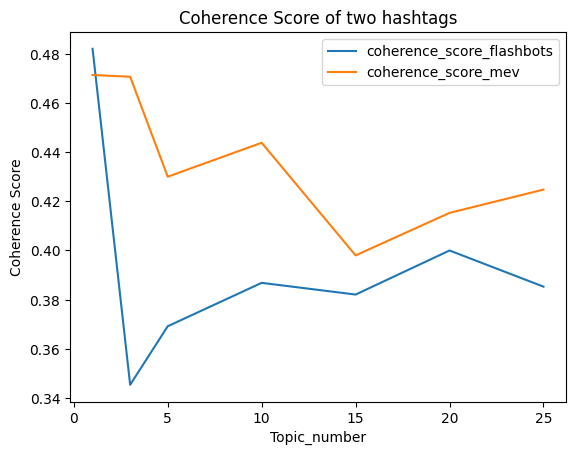

In [42]:
# # Draw the coherence plot line
# coherence_score=[0.482017,0.34539433,0.36919,0.386843,0.382085324,0.4,0.3853]
# topic_number =[1,3,5,10,15,20,25]
# plt.plot(topic_number, coherence_score)
# plt.title('Coherence Score of #MEV')
# plt.xlabel('Topic_number')
# plt.ylabel('Coherence Score')
# plt.show()

coherence_score=[0.482017,0.34539433,0.36919,0.386843,0.382085324,0.4,0.3853]
topic_number =[1,3,5,10,15,20,25]

coherence_score2=[0.47135699145349885, 0.47065381286112234, 0.43,0.44379396844508057, 0.398002388344385, 0.41529477988286356, 0.42475512190478654]

plt.plot(topic_number, coherence_score,label = "coherence_score_flashbots" )
plt.plot(topic_number, coherence_score2,label = "coherence_score_mev")
plt.title('Coherence Score of two hashtags')
plt.xlabel('Topic_number')
plt.ylabel('Coherence Score')
plt.legend()
plt.savefig('Coherence score of #MEV and #flashbots')
plt.show()

In [43]:
# number of topics
num_topics =1
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics, random_state=100, alpha=0.01,eta=0.91)
# Print the Keyword in the 15 topics
doc_lda = lda_model[corpus]

In [44]:
# Compute Coherence Score

coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4816071708776849


In [46]:
# number of topics
num_topics = 5
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics, random_state=0)
# Print the Keyword in the 15 topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

# Visualize the topics
pyLDAvis.enable_notebook()
lda_viz = gensimvis.prepare(lda_model, corpus,id2word)
lda_viz

[(0, '0.065*"flashbots" + 0.027*"mev" + 0.011*"ethereum" + 0.011*"mist" + 0.010*"eth" + 0.006*"mistx" + 0.004*"defi" + 0.004*"gas" + 0.004*"miners" + 0.003*"using"'), (1, '0.037*"flashbots" + 0.014*"mev" + 0.008*"riverfrontrocks" + 0.006*"ethereum" + 0.005*"mist" + 0.005*"ftsd_riverfront" + 0.004*"fll" + 0.003*"tx" + 0.003*"transactions" + 0.003*"goflashes"'), (2, '0.039*"flashbots" + 0.038*"mev" + 0.012*"eth" + 0.007*"ethereum" + 0.006*"miners" + 0.005*"labrys" + 0.004*"gt" + 0.003*"validators" + 0.003*"defi" + 0.003*"mistx"'), (3, '0.046*"flashbots" + 0.016*"mev" + 0.015*"new" + 0.014*"help" + 0.014*"support" + 0.014*"nftshill" + 0.014*"us" + 0.014*"shill" + 0.014*"opensea" + 0.014*"artist"'), (4, '0.048*"flashbots" + 0.011*"mev" + 0.006*"mist" + 0.005*"eth" + 0.005*"nft" + 0.004*"opensea" + 0.004*"new" + 0.004*"defi" + 0.004*"gas" + 0.004*"help"')]


/home/luyao/.local/share/virtualenvs/blockchain-ethics-3DrjvFmO/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/luyao/.local/share/virtualenvs/blockchain-ethics-3DrjvFmO/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/luyao/.local/share/virtualenvs/blockchain-ethics-3DrjvFmO/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/luyao/.local/share/virtualenvs/blockchain-ethics-3DrjvFmO/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see t

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.030803  0.030998       1        1  36.284566
3      0.112088  0.026487       2        1  20.436197
4      0.023454 -0.046656       3        1  16.715788
2     -0.066465  0.047332       4        1  16.157846
1     -0.038275 -0.058161       5        1  10.405603, topic_info=             Term       Freq      Total Category  logprob  loglift
1378     nftshill  48.000000  48.000000  Default  30.0000  30.0000
1380   openseanft  48.000000  48.000000  Default  29.0000  29.0000
1376         grow  48.000000  48.000000  Default  28.0000  28.0000
1381   polygonnft  48.000000  48.000000  Default  27.0000  27.0000
1383  shizzlebotz  48.000000  48.000000  Default  26.0000  26.0000
...           ...        ...        ...      ...      ...      ...
114         today   2.550182  14.730358   Topic5  -6.3425   0.5091
2390        mistx   3.301303  54.552863   Topic5  -6.0843  -0.5420
123         great   2.751799  22.382801   Topic5  -6.2664   0.1668
769        miners   2.855666  36.665729   Topic5  -6.2293  -0.2897
1186         nfts   2.482206  19.536436   Topic5  -6.3695   0.1997

[383 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
3004      4  0.689020  absorbed
1175      1  0.276908   address
1175      2  0.069227   address
1175      3  0.415363   address
1175      4  0.069227   address
...     ...       ...       ...
834       1  0.874574   youtube
834       5  0.145762   youtube
1840      3  0.692396      yung
1605      2  0.451940        из
3659      5  0.763146      取消交易

[731 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 5, 3, 2])

In [48]:
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics, random_state=0)
# Print the Keyword in the 15 topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

lda_viz = gensimvis.prepare(lda_model, corpus,id2word)
lda_viz

[(0, '0.065*"flashbots" + 0.030*"mev" + 0.011*"eth" + 0.010*"ethereum" + 0.008*"mist" + 0.005*"miners" + 0.004*"thegostep" + 0.004*"bots" + 0.004*"defi" + 0.003*"using"'), (1, '0.036*"flashbots" + 0.026*"mev" + 0.006*"riverfrontrocks" + 0.005*"ethereum" + 0.005*"ftsd_riverfront" + 0.005*"miner" + 0.004*"goflashes" + 0.004*"using" + 0.004*"miners" + 0.004*"transaction"'), (2, '0.043*"flashbots" + 0.033*"mev" + 0.014*"eth" + 0.010*"gt" + 0.008*"ethereum" + 0.007*"miners" + 0.007*"labrys" + 0.005*"validators" + 0.004*"ceo" + 0.004*"us"'), (3, '0.043*"flashbots" + 0.017*"mev" + 0.006*"mist" + 0.005*"team" + 0.005*"ethereum" + 0.005*"eth" + 0.005*"work" + 0.004*"mistxlabs" + 0.004*"first" + 0.004*"great"'), (4, '0.047*"flashbots" + 0.013*"mev" + 0.006*"eth" + 0.005*"riverfrontrocks" + 0.005*"ethereum" + 0.004*"research" + 0.004*"defi" + 0.003*"fll" + 0.003*"day" + 0.003*"thegostep"'), (5, '0.047*"flashbots" + 0.020*"mev" + 0.004*"rpc" + 0.004*"eth" + 0.004*"metamask" + 0.003*"mist" + 0.003*

/home/luyao/.local/share/virtualenvs/blockchain-ethics-3DrjvFmO/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/luyao/.local/share/virtualenvs/blockchain-ethics-3DrjvFmO/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/luyao/.local/share/virtualenvs/blockchain-ethics-3DrjvFmO/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/luyao/.local/share/virtualenvs/blockchain-ethics-3DrjvFmO/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see t

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.039843 -0.071655       1        1  20.333581
7      0.146592  0.051282       2        1  14.651807
9      0.142945 -0.036429       3        1  12.714373
8     -0.022458 -0.120244       4        1  12.448273
2     -0.058314  0.014357       5        1   9.631150
5     -0.051596  0.045331       6        1   7.376426
4     -0.040607  0.053716       7        1   6.784750
3     -0.057633  0.039460       8        1   6.615192
1     -0.035983  0.012154       9        1   5.000856
6      0.016897  0.012027      10        1   4.443592, topic_info=             Term       Freq      Total Category  logprob  loglift
1376         grow  51.000000  51.000000  Default  30.0000  30.0000
1378     nftshill  51.000000  51.000000  Default  29.0000  29.0000
1381   polygonnft  51.000000  51.000000  Default  28.0000  28.0000
1383  shizzlebotz  51.000000  51.000000  Default  27.0000  27.0000
1380   openseanft  51.000000  51.000000  Default  26.0000  26.0000
...           ...        ...        ...      ...      ...      ...
62         crypto   1.891174  29.263983  Topic10  -5.7905   0.3745
1095         help   1.963567  61.171741  Topic10  -5.7530  -0.3252
2390        mistx   1.806215  54.267355  Topic10  -5.8365  -0.2890
1379      opensea   1.717330  56.689695  Topic10  -5.8870  -0.3831
475           gas   1.680331  40.974806  Topic10  -5.9087  -0.0803

[750 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
378       9  0.758365     ability
3072      2  0.606066         ace
251       1  0.244900       added
251       3  0.244900       added
251       8  0.244900       added
...     ...       ...         ...
219       6  0.295358  zeroxbrock
219       7  0.295358  zeroxbrock
219       8  0.590716  zeroxbrock
1301      6  0.718626    比技术文章更科普
568       5  0.678509   的另一个里程碑事件

[1611 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 8, 10, 9, 3, 6, 5, 4, 2, 7])

In [50]:
# number of topics
num_topics = 15
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics, random_state=0)
# Print the Keyword in the 15 topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

lda_viz = gensimvis.prepare(lda_model, corpus,id2word)
lda_viz

[(0, '0.061*"flashbots" + 0.027*"mev" + 0.010*"ethereum" + 0.009*"eth" + 0.008*"mist" + 0.007*"mistx" + 0.006*"defi" + 0.004*"bundles" + 0.004*"gas" + 0.004*"community"'), (1, '0.038*"flashbots" + 0.018*"mev" + 0.006*"riverfrontrocks" + 0.006*"ftsd_riverfront" + 0.005*"transaction" + 0.005*"using" + 0.004*"miners" + 0.004*"ethereum" + 0.004*"mist" + 0.003*"community"'), (2, '0.045*"flashbots" + 0.035*"mev" + 0.019*"eth" + 0.013*"ethereum" + 0.010*"miners" + 0.006*"gt" + 0.005*"labrys" + 0.004*"mistx" + 0.004*"extractable" + 0.004*"value"'), (3, '0.041*"flashbots" + 0.019*"mev" + 0.012*"eth" + 0.008*"mist" + 0.006*"team" + 0.005*"great" + 0.004*"first" + 0.004*"like" + 0.004*"going" + 0.004*"bertcmiller"'), (4, '0.050*"flashbots" + 0.017*"mev" + 0.006*"eth" + 0.006*"mist" + 0.005*"defi" + 0.005*"need" + 0.004*"huge" + 0.004*"day" + 0.004*"amazing" + 0.004*"gwei"'), (5, '0.034*"flashbots" + 0.012*"mev" + 0.007*"rpc" + 0.006*"metamask" + 0.006*"thegostep" + 0.005*"ethereum" + 0.004*"gas" 

/home/luyao/.local/share/virtualenvs/blockchain-ethics-3DrjvFmO/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/luyao/.local/share/virtualenvs/blockchain-ethics-3DrjvFmO/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/luyao/.local/share/virtualenvs/blockchain-ethics-3DrjvFmO/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/luyao/.local/share/virtualenvs/blockchain-ethics-3DrjvFmO/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see t

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.177364  0.006541       1        1  13.645812
0      0.036254  0.086054       2        1  11.839345
12    -0.107040 -0.009574       3        1   9.095715
8      0.019971  0.032964       4        1   8.801391
10     0.036618  0.090162       5        1   8.481971
2      0.044361  0.101579       6        1   7.876223
11     0.051912 -0.031113       7        1   6.785108
7     -0.158030  0.011718       8        1   5.631577
13     0.060759 -0.025231       9        1   5.169864
3      0.047581  0.000714      10        1   4.911116
14     0.031450 -0.005646      11        1   4.489447
1      0.042345 -0.074135      12        1   4.074601
4      0.053583 -0.046590      13        1   3.354653
5      0.053143 -0.062652      14        1   3.064967
6     -0.035544 -0.074792      15        1   2.778211, topic_info=             Term       Freq      Total Category  logprob  loglift
1381   polygonnft  51.000000  51.000000  Default  30.0000  30.0000
1376         grow  51.000000  51.000000  Default  29.0000  29.0000
1383  shizzlebotz  51.000000  51.000000  Default  28.0000  28.0000
1378     nftshill  51.000000  51.000000  Default  27.0000  27.0000
1380   openseanft  51.000000  51.000000  Default  26.0000  26.0000
...           ...        ...        ...      ...      ...      ...
1376         grow   1.112533  51.620901  Topic15  -5.8514  -0.2539
1380   openseanft   1.112666  51.833605  Topic15  -5.8513  -0.2579
1381   polygonnft   1.112594  51.813118  Topic15  -5.8514  -0.2576
1375       artist   1.112766  52.706979  Topic15  -5.8512  -0.2745
1383  shizzlebotz   1.112600  51.978646  Topic15  -5.8514  -0.2608

[1083 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1232      7  0.692306           aa
3471      5  0.685007   aakohynkwd
4030      2  0.667326        abfbv
3072      8  0.797539          ace
1287     15  0.800806       adabfa
...     ...       ...          ...
2922     10  0.712271          新功能
2924     10  0.712271     没有额外的手续费
568       6  0.654628    的另一个里程碑事件
3662      1  0.570859  看看您过去因为被机器人
3665      1  0.570831           费用

[2265 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 1, 13, 9, 11, 3, 12, 8, 14, 4, 15, 2, 5, 6, 7])

In [51]:
# number of topics
num_topics = 20
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics, random_state=0)
# Print the Keyword in the 15 topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

lda_viz = gensimvis.prepare(lda_model, corpus,id2word)
lda_viz

[(0, '0.067*"flashbots" + 0.028*"mev" + 0.013*"ethereum" + 0.012*"mist" + 0.010*"eth" + 0.006*"defi" + 0.005*"thread" + 0.005*"community" + 0.005*"miners" + 0.004*"bundles"'), (1, '0.035*"flashbots" + 0.012*"mev" + 0.008*"riverfrontrocks" + 0.006*"transaction" + 0.006*"ftsd_riverfront" + 0.005*"tx" + 0.005*"ethereum" + 0.005*"next" + 0.005*"today" + 0.004*"front"'), (2, '0.042*"flashbots" + 0.030*"mev" + 0.017*"eth" + 0.016*"miners" + 0.007*"ethereum" + 0.006*"labrys" + 0.006*"validators" + 0.004*"ceo" + 0.004*"gt" + 0.004*"miner"'), (3, '0.036*"flashbots" + 0.016*"mev" + 0.007*"dex" + 0.007*"eth" + 0.007*"first" + 0.005*"mist" + 0.005*"like" + 0.004*"early" + 0.004*"see" + 0.004*"ethereum"'), (4, '0.041*"flashbots" + 0.012*"mev" + 0.007*"eth" + 0.006*"gas" + 0.006*"transactions" + 0.005*"token" + 0.005*"like" + 0.005*"low" + 0.004*"nft" + 0.004*"mist"'), (5, '0.049*"flashbots" + 0.021*"mev" + 0.006*"gas" + 0.005*"protect" + 0.004*"ethereum" + 0.004*"eth" + 0.004*"research" + 0.004*"me

/home/luyao/.local/share/virtualenvs/blockchain-ethics-3DrjvFmO/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/luyao/.local/share/virtualenvs/blockchain-ethics-3DrjvFmO/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/luyao/.local/share/virtualenvs/blockchain-ethics-3DrjvFmO/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/luyao/.local/share/virtualenvs/blockchain-ethics-3DrjvFmO/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see t

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.141420  0.031601       1        1  11.111151
0      0.029404 -0.099353       2        1   8.234847
12    -0.084745  0.014524       3        1   7.012131
16    -0.035134 -0.000669       4        1   6.395630
11     0.074969  0.029303       5        1   6.355381
9     -0.110990 -0.047350       6        1   6.352926
8      0.043607 -0.127246       7        1   5.889257
10     0.036190 -0.083125       8        1   5.308584
19    -0.146249  0.005562       9        1   4.911837
18    -0.039628  0.043468      10        1   4.647241
17     0.008940 -0.049173      11        1   4.416942
5      0.075681  0.018326      12        1   3.928667
2      0.056088  0.070780      13        1   3.909673
14     0.054078  0.030042      14        1   3.884271
13     0.075047  0.057077      15        1   3.726213
15    -0.107494  0.030126      16        1   3.133226
3      0.014440  0.004559      17        1   2.994763
4      0.080489  0.032788      18        1   2.881264
6      0.051396  0.042011      19        1   2.484408
1      0.065332 -0.003251      20        1   2.421587, topic_info=             Term       Freq      Total Category  logprob  loglift
1381   polygonnft  52.000000  52.000000  Default  30.0000  30.0000
1376         grow  52.000000  52.000000  Default  29.0000  29.0000
1380   openseanft  52.000000  52.000000  Default  28.0000  28.0000
1378     nftshill  52.000000  52.000000  Default  27.0000  27.0000
1383  shizzlebotz  52.000000  52.000000  Default  26.0000  26.0000
...           ...        ...        ...      ...      ...      ...
1447      bundles   0.820263  14.890785  Topic20  -6.0188   0.8219
625          year   0.789693   9.364345  Topic20  -6.0568   1.2477
1785         mist   0.914204  97.246753  Topic20  -5.9104  -0.9462
62         crypto   0.790756  29.553296  Topic20  -6.0555   0.0998
587            pm   0.665170  21.348500  Topic20  -6.2284   0.2521

[1423 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1232      5  0.639852        aa
4030      2  0.688367     abfbv
378      20  0.738149   ability
1973      2  0.251333      able
1973      9  0.251333      able
...     ...       ...       ...
2924     14  0.699598  没有额外的手续费
199       9  0.745297     的所有交易
850       8  0.708662      社区通过
2909      6  0.692662      进行交易
1104     19  0.735157        针对

[2918 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 1, 13, 17, 12, 10, 9, 11, 20, 19, 18, 6, 3, 15, 14, 16, 4, 5, 7, 2])

In [52]:
# number of topics
num_topics =25
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics, random_state=0)
# Print the Keyword in the 15 topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

lda_viz = gensimvis.prepare(lda_model, corpus,id2word)
lda_viz

[(17, '0.042*"flashbots" + 0.018*"mev" + 0.012*"mist" + 0.008*"mistx" + 0.007*"pm" + 0.006*"thegostep" + 0.006*"time" + 0.006*"link" + 0.006*"utc" + 0.005*"community"'), (23, '0.063*"flashbots" + 0.026*"mev" + 0.010*"eth" + 0.009*"ethereum" + 0.006*"labrys" + 0.005*"using" + 0.005*"us" + 0.005*"defi" + 0.005*"alchemist" + 0.005*"gt"'), (1, '0.038*"flashbots" + 0.022*"mev" + 0.007*"pm" + 0.007*"community" + 0.005*"work" + 0.005*"transactions" + 0.005*"mist" + 0.004*"ethereum" + 0.004*"wallet" + 0.004*"blocknative"'), (19, '0.044*"flashbots" + 0.035*"mev" + 0.009*"support" + 0.009*"help" + 0.009*"us" + 0.009*"new" + 0.009*"opensea" + 0.008*"jdpe" + 0.008*"openseanft" + 0.008*"artist"'), (22, '0.049*"flashbots" + 0.023*"us" + 0.022*"artist" + 0.022*"nftshill" + 0.022*"sizq" + 0.022*"grow" + 0.022*"shill" + 0.022*"shizzlebotz" + 0.022*"opensea" + 0.022*"support"'), (21, '0.058*"flashbots" + 0.032*"mev" + 0.008*"mist" + 0.007*"uniswap" + 0.007*"work" + 0.007*"us" + 0.006*"eth" + 0.006*"merg

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
22     0.184818  0.000914       1        1  8.650461
0     -0.064709  0.076016       2        1  8.568536
23    -0.025153  0.062529       3        1  5.905579
12    -0.001168  0.066197       4        1  5.178387
16    -0.015267  0.089349       5        1  4.999686
8     -0.054021  0.064797       6        1  4.772330
10    -0.053413  0.049710       7        1  4.346464
11    -0.068877 -0.000730       8        1  4.338509
9      0.115320  0.019965       9        1  4.254435
24     0.128397 -0.045880      10        1  4.143548
2     -0.090399  0.032873      11        1  3.998853
21     0.068505  0.043328      12        1  3.987279
7      0.143695  0.008934      13        1  3.794501
19     0.092983  0.022052      14        1  3.664737
13    -0.040141 -0.015819      15        1  3.658793
17     0.009618 -0.000281      16        1  3.531836
14    -0.075583  0.024527      17        1  3.329173
4     -0.067101 -0.050994      18        1  3.100659
3     -0.068431 -0.068545      19        1  2.904711
18     0.012908 -0.015380      20        1  2.748333
5     -0.076092 -0.029441      21        1  2.475803
1     -0.052449 -0.071932      22        1  2.305184
15    -0.009664 -0.076374      23        1  2.185751
6      0.051112 -0.079761      24        1  1.633192
20    -0.044888 -0.106055      25        1  1.523262, topic_info=            Term        Freq       Total Category  logprob  loglift
54           mev  305.000000  305.000000  Default  30.0000  30.0000
1377        jdpe   55.000000   55.000000  Default  29.0000  29.0000
1384        sizq   55.000000   55.000000  Default  28.0000  28.0000
1376        grow   58.000000   58.000000  Default  27.0000  27.0000
1380  openseanft   58.000000   58.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
507         went    0.593096    2.638160  Topic25  -5.8795   2.6918
502   seamlessly    0.593092    2.030281  Topic25  -5.8795   2.9537
2279  cancelling    0.593092    2.001600  Topic25  -5.8795   2.9680
2370   countdown    0.593091    2.038424  Topic25  -5.8795   2.9497
427        merge    0.593088   19.569494  Topic25  -5.8795   0.6879

[1710 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1232     10  0.624052         aa
1279     24  0.820692        aae
2367     25  0.771312  abandeali
815      16  0.692196      abebe
4030      2  0.655003      abfbv
...     ...       ...        ...
1303      4  0.667397        科学家
1303     11  0.333699        科学家
570      15  0.701222         表示
1304      4  0.667362       链上套利
1304     11  0.333681       链上套利

[3538 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[23, 1, 24, 13, 17, 9, 11, 12, 10, 25, 3, 22, 8, 20, 14, 18, 15, 5, 4, 19, 6, 2, 16, 7, 21])

In [53]:
# number of topics
num_topics = 25
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics, random_state=0)
# Print the Keyword in the 15 topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

lda_viz = gensimvis.prepare(lda_model, corpus,id2word)
lda_viz

[(17, '0.042*"flashbots" + 0.018*"mev" + 0.012*"mist" + 0.008*"mistx" + 0.007*"pm" + 0.006*"thegostep" + 0.006*"time" + 0.006*"link" + 0.006*"utc" + 0.005*"community"'), (23, '0.063*"flashbots" + 0.026*"mev" + 0.010*"eth" + 0.009*"ethereum" + 0.006*"labrys" + 0.005*"using" + 0.005*"us" + 0.005*"defi" + 0.005*"alchemist" + 0.005*"gt"'), (1, '0.038*"flashbots" + 0.022*"mev" + 0.007*"pm" + 0.007*"community" + 0.005*"work" + 0.005*"transactions" + 0.005*"mist" + 0.004*"ethereum" + 0.004*"wallet" + 0.004*"blocknative"'), (19, '0.044*"flashbots" + 0.035*"mev" + 0.009*"support" + 0.009*"help" + 0.009*"us" + 0.009*"new" + 0.009*"opensea" + 0.008*"jdpe" + 0.008*"openseanft" + 0.008*"artist"'), (22, '0.049*"flashbots" + 0.023*"us" + 0.022*"artist" + 0.022*"nftshill" + 0.022*"sizq" + 0.022*"grow" + 0.022*"shill" + 0.022*"shizzlebotz" + 0.022*"opensea" + 0.022*"support"'), (21, '0.058*"flashbots" + 0.032*"mev" + 0.008*"mist" + 0.007*"uniswap" + 0.007*"work" + 0.007*"us" + 0.006*"eth" + 0.006*"merg

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
22     0.184818  0.000914       1        1  8.650461
0     -0.064709  0.076016       2        1  8.568536
23    -0.025153  0.062529       3        1  5.905579
12    -0.001168  0.066197       4        1  5.178387
16    -0.015267  0.089349       5        1  4.999686
8     -0.054021  0.064797       6        1  4.772330
10    -0.053413  0.049710       7        1  4.346464
11    -0.068877 -0.000730       8        1  4.338509
9      0.115320  0.019965       9        1  4.254435
24     0.128397 -0.045880      10        1  4.143548
2     -0.090399  0.032873      11        1  3.998853
21     0.068505  0.043328      12        1  3.987279
7      0.143695  0.008934      13        1  3.794501
19     0.092983  0.022052      14        1  3.664737
13    -0.040141 -0.015819      15        1  3.658793
17     0.009618 -0.000281      16        1  3.531836
14    -0.075583  0.024527      17        1  3.329173
4     -0.067101 -0.050994      18        1  3.100659
3     -0.068431 -0.068545      19        1  2.904711
18     0.012908 -0.015380      20        1  2.748333
5     -0.076092 -0.029441      21        1  2.475803
1     -0.052449 -0.071932      22        1  2.305184
15    -0.009664 -0.076374      23        1  2.185751
6      0.051112 -0.079761      24        1  1.633192
20    -0.044888 -0.106055      25        1  1.523262, topic_info=            Term        Freq       Total Category  logprob  loglift
54           mev  305.000000  305.000000  Default  30.0000  30.0000
1377        jdpe   55.000000   55.000000  Default  29.0000  29.0000
1384        sizq   55.000000   55.000000  Default  28.0000  28.0000
1376        grow   58.000000   58.000000  Default  27.0000  27.0000
1380  openseanft   58.000000   58.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
507         went    0.593096    2.638160  Topic25  -5.8795   2.6918
502   seamlessly    0.593092    2.030281  Topic25  -5.8795   2.9537
2279  cancelling    0.593092    2.001600  Topic25  -5.8795   2.9680
2370   countdown    0.593091    2.038424  Topic25  -5.8795   2.9497
427        merge    0.593088   19.569494  Topic25  -5.8795   0.6879

[1710 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1232     10  0.624052         aa
1279     24  0.820692        aae
2367     25  0.771312  abandeali
815      16  0.692196      abebe
4030      2  0.655003      abfbv
...     ...       ...        ...
1303      4  0.667397        科学家
1303     11  0.333699        科学家
570      15  0.701222         表示
1304      4  0.667362       链上套利
1304     11  0.333681       链上套利

[3538 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[23, 1, 24, 13, 17, 9, 11, 12, 10, 25, 3, 22, 8, 20, 14, 18, 15, 5, 4, 19, 6, 2, 16, 7, 21])

#### Determine parameters alpha and beta

In [55]:
# number of topics
num_topics = 1
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics, random_state=100, alpha=0.01,eta=0.91)
# Print the Keyword in the 15 topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.052*"flashbots" + 0.023*"mev" + 0.008*"ethereum" + 0.007*"eth" + 0.007*"mist" + 0.005*"new" + 0.005*"us" + 0.004*"help" + 0.004*"support" + 0.004*"opensea"')]


In [56]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4816071708776849


In [57]:
# number of topics
num_topics =20
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics, random_state=100, alpha=0.3,eta=0.91)
# Print the Keyword in the 15 topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.009*"flashbots" + 0.002*"mev" + 0.002*"ethereum" + 0.001*"transactions" + 0.001*"nft" + 0.001*"defi" + 0.001*"eth" + 0.001*"community" + 0.001*"bots" + 0.001*"way"'), (1, '0.018*"flashbots" + 0.011*"mev" + 0.004*"mist" + 0.003*"eth" + 0.003*"ethereum" + 0.003*"mistx" + 0.001*"crucible" + 0.001*"thegostep" + 0.001*"miners" + 0.001*"copper"'), (2, '0.014*"flashbots" + 0.004*"mev" + 0.003*"eth" + 0.003*"ethereum" + 0.003*"new" + 0.003*"us" + 0.003*"opensea" + 0.002*"shizzlebotz" + 0.002*"artist" + 0.002*"help"'), (3, '0.004*"flashbots" + 0.002*"mev" + 0.001*"eth" + 0.001*"thegostep" + 0.001*"crypto" + 0.001*"gasless" + 0.001*"token" + 0.001*"mistx" + 0.001*"new" + 0.001*"metamask"'), (4, '0.008*"flashbots" + 0.002*"mev" + 0.002*"ethereum" + 0.001*"eth" + 0.001*"mist" + 0.001*"one" + 0.001*"gas" + 0.001*"made" + 0.001*"thegostep" + 0.001*"riverfrontrocks"'), (5, '0.007*"flashbots" + 0.003*"mev" + 0.002*"eth" + 0.002*"ethereum" + 0.001*"thegostep" + 0.001*"defi" + 0.001*"new" + 0.00

In [58]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.40496330603472597


In [60]:
# number of topics
num_topics =1
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics, random_state=100, alpha="symmetric",eta=0.91)
# Print the Keyword in the 15 topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.052*"flashbots" + 0.023*"mev" + 0.008*"ethereum" + 0.007*"eth" + 0.007*"mist" + 0.005*"new" + 0.005*"us" + 0.004*"help" + 0.004*"support" + 0.004*"opensea"')]


In [61]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4816071708776849
